# LEVANTAR CLUSTER DE DASK EN EL FT-III

La librería permite levantar un cluster dask en  el FT3 de forma sencilla. Los ficheros de la librería son:

* dask_cluster.py: script python con todas las funciones necesarias para levantar el *scheduler* y los *workers* de un *cluster* de **dask**. Se puede utilizar como una línea de comandos:
    * python  dask_cluster.py -h: nos da una lista con los posibles inputs:
    * python  dask_cluster.py  --scheduler: levanta solo un *scheduler*
    * python  dask_cluster.py --worker: levanta un  worker y lo conecta al cluster especificado en el fichero **scheduler_info.json** (el fichero **debe existir**)
    * python  dask_cluster.py --worker -scheduler_address tcp://10.120.10.7:8085 : levanta 1 worker y lo conecta al *scheduler* ubicado en la dirección IP proporcionada (en el ejemplo lo conectaría a un scheduler en tcp://10.120.10.7:8085)
    * python  dask_cluster.py --ssh_file: permite crear el fichero con el comando necesario para la redirección de puertos para conectarse al dashboard de dask (el fichero creado siempre será el mismo: **ssh_command.txt** y se creará en el directorio donde se lance el *scheduler*)
* dask_submit_workers.sh: script en bash que lanza al sistema de colas varios *workers*. Lanza tantos workers como se le indique en el número de tareas de la reserva!! El script está diseñado para utilizar un fichero: **scheduler_info.json** que genera el *scheduler*. Para hacer esto debe primero existir un *scheduler* levantado!!
* dask_cluster_submit.sh: script que lanza a cola el cluster completo (*scheduler* y *workers*). La reserva de recursos debe ser tal que el número de tareas solicitadas sea igual al número de *workers* deseados + 1 (que será la tarea que se encargue del *scheduler*).

## 1. Dask: Configuración 1

En este caso tenemos la siguiente configuración: tenenmos un jupyter-notebook levantado y queremos levantar un *scheduler* de dask en la reserva en la que tenemos el jupyter-notebook y vamos a lanzar *workers* al sistema de colas que se irán conectando al *scheduler* a medida que se vaya ejecutando la reserva. La configuración sería la siguiente:

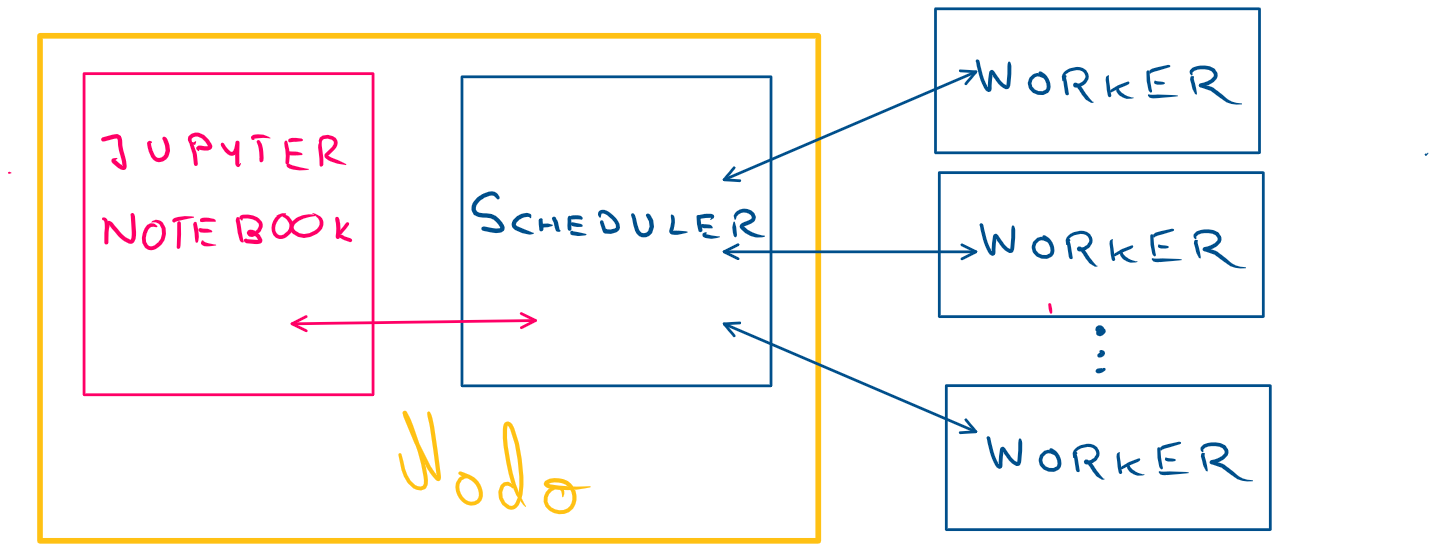

Para poder ejecutar esta configuración debemos hacer lo siguiente:

* Abro el terminal desde que lancé el Notebook.
* Cargo los modulos o entornos conda necesarios.
* Ejecuto:
    * python dask_cluster.py --scheduler
* Se crea automáticamente un fichero **scheduler_info.json** con la info del scheduler.
* Este fichero se le puede proporcionar al Client de dask.

Supongamos que ejecutamos este paso. En la siguiente celda conectamos el jupyter-notebook al *scheduler*:


In [ ]:
path_to_schedule_json = "/home/cesga/gferro/dask_cluster/scheduler_info.json"
from distributed import Client
client = Client(
    scheduler_file = path_to_schedule_json)

In [ ]:
client

El cliente así creado solo tiene el *scheduler* hay que añadirle los *workers*.

Para ellos se pueden ir añadiendo *workers* manualmente del siguiente modo:
* python dask_cluster.py --worker

Esta forma utiliza el json: **scheduler_info.json** para que los *workers* sepan donde está el *scheduler*.
Se puede proporcionar la direccion del *scheduler* directamente del siguiente modo:

* Ejemplo: python dask_cluster.py --worker -scheduler_address "tcp://10.120.10.7:8085"

Los *workers* se pueden lanzar al sistema de colas y unirse al *scheduler* a medida que vayan entrando. 
Se puede usar el script:

* sbatch  dask_submit_workers.sh

### Dashboard

Si queremos acceder al dashboard hay que ejecutar, en el nodo donde se lanzo el scheduler, el siguiente comando:

* python dask_cluster.py --ssh_file

Esteo creará en el directorio un fichero **ssh_command.txt** con el comando completo para hacer la redirección de puertos necesaria para poder acceder al dashboard de dask.

Cuando se ejecute el comando en el terminal solo tendremos que ejecutar en un navegador la orden **localhost:PUERTO** donde **PUERTO** se puede encontrar en el comando necesario para la redireccion de puertos.

* Ejemplo. Supongamos que el comando que encontramos en **ssh_command.txt** es:
    * ssh -t -L 8787:localhost:8787 gferro@ft3.cesga.es ssh -L 8787:172.30.211.22:8787 ilk-249
* Lo ejecutamos en un terminal.
* Nos vamos al navegador y pegamos: **localhost:8787**

Yaa tendríamos acceso al dashboard de dask!

## 2. Dask: Configuracion 2

En este caso la configuración que queremos es un poco más general. Suponemos que tendremos un jupyter-notebook y queremos levantar un *cluster* de **dask** completo en el FT3. Además queremos conectar el jupyter notebook a dicho *cluster*. La configuración se describe en la siguiente figura:

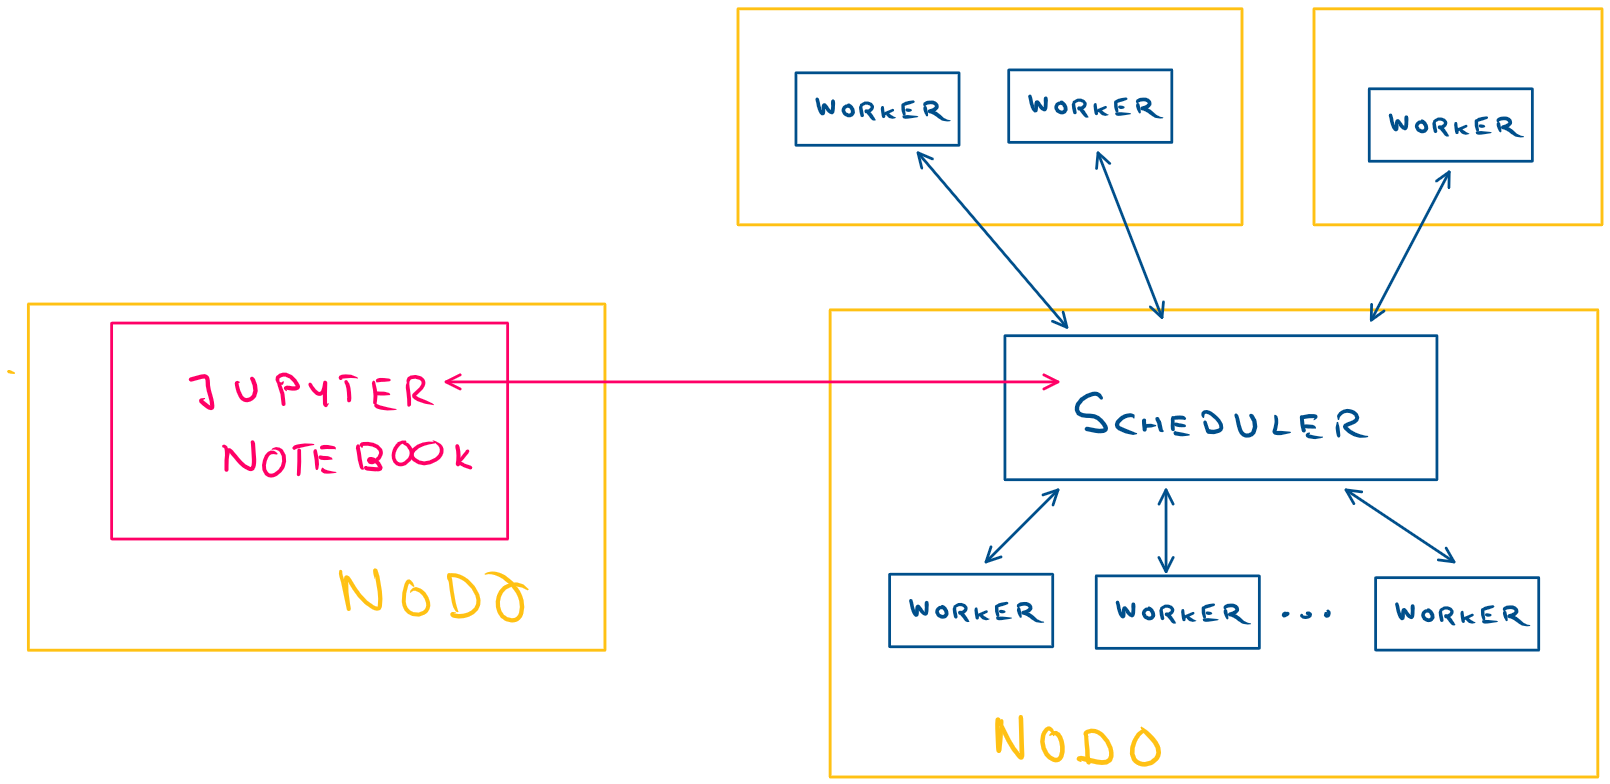


Para levantar el *cluster* completo (*scheduler* y *workers*) en el mismo trabajo debemos configurar los recursos computacionales que deseamos en el script **dask_cluster_submit.sh** y lanzarlo al sistema de colas con **sbatch**:

* sbatch  dask_cluster_submit.sh

A continuación podemos conectar el jupyter al *scheduler* (una vez el cluster esté levantado) sin más que porporcionarle el fichero de **json** de configuración que crea el *scheduler*:

In [ ]:
from distributed import Client

In [ ]:
path_to_schedule_json = "/home/cesga/gferro/dask_cluster/scheduler_info.json"
client = Client(
    scheduler_file = path_to_schedule_json)

In [ ]:
client

### Dashboard de Dask

En este caso si todo fue bien cuando se levante el cluster el fichero **ssh_command.txt** se generará automaticamente en el directorio de lanzamiento.

Los pasos son los mismos que los explicados anteriormente.

## 3. Notas

Cosas que hay que tener en cuenta:

Las versiones cargadas de la librería **dask** tienen que ser consistentes en todos los trabajos, es decir debemos lanzar los *workers*, el *scheduler* y el jupyter-notebook que queremos conectar al *scheduler* con las mimas librerías de dask!!!

Toda la librería se basa en que el *scheduler* de **dask** es capaz de generar un fichero json (**scheduler_info.json**) donde registra toda la información necesaria de conectividad con el *scheduler*. Este fichero es capital ya que tanto los *workers* como los *notebooks* lo van a utilizar para conectarse al *scheduler*. 

Este fichero (**scheduler_info.json**) se genera en el directorio desde donde se lanza el *scheduler* y los workers van a ir a buscarlo a ese directorio! (en futuras versiones pretendo que se le pueda indicar al *scheduler* donde y con que nombre guardar dicho fichero y que se le pueda decir al worker el *path* y el nombre de dicho fichero).

## 4. Ejemplo de funcionamiento

Vamos a ejecutar un ejemplo sencillo de como funciona dask. Está tomado de:

https://nbviewer.org/github/danbochman/Open-Source-Spotlight/blob/master/Dask/Dask.ipynb



In [ ]:
from time import sleep

#Espera 1 segundo y suma uno a la entrada

def inc(x):
    sleep(1)
    return x + 1


Sobre 4 números la operación tardará 4 segundos!

In [ ]:
%%time

data = [1, 2, 3, 4]

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
print(results)

## dask! 

Ejecutamos la configuración 2!!

In [ ]:
from distributed import Client

In [ ]:
path_to_schedule_json = '/home/cesga/gferro/dfailde/dask_cluster/scheduler_info.json'

In [ ]:
client = Client(scheduler_file = path_to_schedule_json)

In [ ]:
client

Hacemos unos pequeños cambios en el código principal para habilitar dask!!

Si tenemos un cluster de 4 *workers* el tiempo de la siguiente celda debe de ser de un poco más de 1 s.

In [ ]:
%%time
results = []

data = [1, 2, 3, 4]

for x in data:
    #enviamos al cluster
    y = client.submit(inc, x, pure=False)
    results.append(y)

#recogemos del cluster    
total = client.gather(results)

print(total)